In [1]:
import numpy as np
import tensorflow as tf

# 랜덤시드 설정
np.random.seed(0)
tf.random.set_seed(0)

2023-01-20 04:52:58.608560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 04:52:58.726490: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


데이터 불러오기 (MNIST)

In [2]:
from tensorflow.keras.datasets import mnist

# train, test를 모두 사용했던 이전과 달리 이번에는 오직 train의 feature만 사용
(X_raw, _), (_, _) = mnist.load_data()

학습을 위한 변수 설정

In [3]:
n_img = X_raw.shape[0]
epoch = 10000     # GAN은 비교적 높은 epoch을 요구하기에 10000으로 설정
n_batch = 100

print(n_img)     # 사용할 손글씨 데이터는 총 6만장으로 구성되어 있음

60000


데이터 전처리

In [4]:
import numpy as np

X_re = X_raw.reshape(n_img, 28, 28, 1)  # (60000, 28, 28) -> (60000, 28, 28, 1)

# 기존 데이터는 0~255로 -1~1의 범위를 갖게하기 위해 아래처럼 계산
# 기존 데이터 - scale_c를 scale_c로 나누면 -1~1의 값을 갖는다.
Scale_c = 255 / 2
X = (X_re - Scale_c) / Scale_c

# 원본 손글씨 데이터의 target data 생성
real_1 = np.ones((n_batch, 1))  # 원본데이터가 실제손글씨면 1
fake_0 = np.zeros((n_batch, 1)) # 원본데이터가 가짜손글씨면 0

Deep Learning 라이브러리 불러오기

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Flatten
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, UpSampling2D

생성자 모델 생성

In [6]:
input_layer1 = Input(shape=(100,))

x1 = Dense(64*7*7)(input_layer1)
x1 = BatchNormalization()(x1)       # 출력된 data를 다시 표준화
x1 = Activation(LeakyReLU(0.3))(x1) # 음수값이 존재하므로 LeakyReLU 사용
x1 = Reshape((7, 7, 64))(x1)    # 출력된 data를 7x7x64의 텐서로 형태를 바꾼다.
x1 = UpSampling2D()(x1)     #UpSampling으로 이미지의 크기를 키운다.
x1 = Conv2D(32, (3, 3), padding='same')(x1) # 아웃풋32, kernel사이즈 (3,3)과 padding을 이용한 크기 보존
x1 = BatchNormalization()(x1)       # 그 결과를 표준화시킨다.
x1 = Activation(LeakyReLU(0.3))(x1)
x1 = UpSampling2D()(x1)

output_layer1 = Conv2D(1, (3,3), padding='same', activation='tanh')(x1)

generator = Model(input_layer1, output_layer1)

generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 3136)              316736    
                                                                 
 batch_normalization (BatchN  (None, 3136)             12544     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 64)       0         
 )                                                           

2023-01-20 04:53:00.212798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 04:53:00.215121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 04:53:00.215389: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 04:53:00.215980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

판별자 모델 생성


In [7]:
input_layer2 = Input(shape=(28, 28, 1))

x2 = Conv2D(64, kernel_size=(5,5), padding='same')(input_layer2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)      # 25%의 데이터는 사용하지 않음
x2 = Conv2D(128, kernel_size=(3,3), padding='same')(x2)
x2 = Activation(LeakyReLU(0.3))(x2)
x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)      # Flatten을 이용해 데이터를 일렬로 펼친다.

output_layer2 = Dense(1, activation='sigmoid')(x2)

discriminator = Model(input_layer2, output_layer2)  # 입력층과 출력층을 이용해 판별모델 설정

#컴파일이란 모델을 학습시키기 위한 학습과정을 설정하는 단계로 compile 함수를 사용하여 설정한다.
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# .trainable은 backpropagation으로 weight update로 학습하지 않아서 False
# weight update로 학습하면 정확도가 오르는데 왜 False로 설정하는가?
# 우리의 목적은 하나의 dataset으로 학습정확도를 향상하는 것이 아니기 때문!
discriminator.trainable = False

discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        1664      
                                                                 
 activation_2 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 activation_3 (Activation)   (None, 28, 28, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 128)       0   

GAN 모델 생성  - 생성자모델과 판별자모델을 연결

In [8]:
input_GAN = Input(shape=(100,))     #100개의 input data에 대해 
output_dis = discriminator(generator(input_GAN))    # 생성자를 통해 이미지 생성 후 판별하는 형태의 output

gan = Model(input_GAN, output_dis)
gan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

gan.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 28, 28, 1)         348161    
                                                                 
 model_1 (Functional)        (None, 1)                 175873    
                                                                 
Total params: 524,034
Trainable params: 341,825
Non-trainable params: 182,209
_________________________________________________________________


학습

In [ ]:
import numpy as np

loss_disc_real = [0]*epoch      # 실제 데이터를 이용해 판별시의 손실
loss_disc_fake = [0]*epoch      # 가짜 데이터를 이용해 판별시의 손실
loss_disc_avg = [0]*epoch       # 위의 두 손실의 평균
loss_gan = [0]*epoch            # GAN 모델의 손실

acc_disc_real = [0]*epoch       # 실제 데이터를 이용해 판별시의 정확도
acc_disc_fake = [0]*epoch       # 가짜 데이터를 이용해 판별시의 정확도
acc_disc_avg = [0]*epoch        # 위의 두 정확도의 평균
acc_gan = [0]*epoch             # GAN 모델의 정확도

for i in range(0, epoch):
    # 실제 데이터 판별을 위해 np.random.randint를 이용해 선택할 실제 데이터의 인덱스를 정함
    # 0~n_img 사이 숫자 중 n_batch개를 선택
    idx = np.random.randint(0, n_img, n_batch)
    imgs = X[idx]
    res_real = discriminator.train_on_batch(imgs, real_1)   # 판별모델의 입력은 모두 실제값이므로 target을 1로 설정
    
    # 가짜 데이터 생성을 위해 np.random.normal을 이용해 N(0, 1^2)인 정규분포에서 size개수만큼 random data 생성
    fake = np.random.normal(0, 1, size=(n_batch, 100))
    gen_imgs = generator.predict(fake)  # 위의 랜덤데이터를 생성모형에 넣고 새로운 가짜를 만든다.
    res_fake = discriminator.train_on_batch(gen_imgs, fake_0) # 만들어진 가짜를 판별기를 이용해 판별, 가짜여서 target은 0
    
    # 판별 손실 평균 & 정확도 평균_ i번째 반복문에서의 손실평균을 의미
    loss_disc_avg_ith = np.add(res_real[0],res_fake[0])*0.5  
    acc_disc_avg_ith = np.add(res_real[1],res_fake[1])*0.5
    
    # GAN 결과
    # 생성모델로 만든 가짜를 실제 데이터로 판별할 확률을 구함
    res_gan = gan.train_on_batch(fake, real_1)

    # 정확도 및 손실
    loss_disc_real[i] = res_real[0]     # 실제와 target데이터 1을 이용해 판별시의 손실
    loss_disc_fake[i] = res_fake[0]     # 가짜와 target데이터 0을 이용해 판별시의 손실
    loss_disc_avg[i] = loss_disc_avg_ith # 위의 두 값의 평균
    loss_gan[i] = res_gan[0]            # GAN 모델의 손실
    
    acc_disc_real[i] = res_real[1]      # 실제와 target데이터 1을 이용해 판별시의 정확도
    acc_disc_fake[i] = res_fake[1]      # 가짜와 target데이터 0을 이용해 판별시의 정확도
    acc_disc_avg[i] = acc_disc_avg_ith  # 위의 두 값의 평균
    acc_gan[i] = res_gan[1]             # GAN 모델의 정확도
    
    # 해당 epoch의 학습결과 출력
    print('epoch:%d'%i,
          ' 판별손실평균:%.4f'%loss_disc_avg_ith, ' 판별정확도평균:%.4f'%acc_disc_avg_ith,
          ' 생성손실:%.4f'%res_gan[0], ' 생성정확도:%.4f'%res_gan[1])

2023-01-20 04:53:01.535388: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


4/4 [==============================] - 0s 4ms/step
epoch:0  판별손실평균:0.9305  판별정확도평균:0.0700  생성손실:0.2250  생성정확도:1.0000
4/4 [==============================] - 0s 1ms/step
epoch:1  판별손실평균:0.4293  판별정확도평균:0.5100  생성손실:0.5734  생성정확도:0.7600
4/4 [==============================] - 0s 1ms/step
epoch:2  판별손실평균:0.2567  판별정확도평균:1.0000  생성손실:0.8280  생성정확도:0.4500
4/4 [==============================] - 0s 1ms/step
epoch:3  판별손실평균:0.0442  판별정확도평균:1.0000  생성손실:0.9798  생성정확도:0.5400
4/4 [==============================] - 0s 1ms/step
epoch:4  판별손실평균:0.0097  판별정확도평균:1.0000  생성손실:0.5289  생성정확도:0.7400
4/4 [==============================] - 0s 1ms/step
epoch:5  판별손실평균:0.0148  판별정확도평균:1.0000  생성손실:0.1726  생성정확도:0.9500
4/4 [==============================] - 0s 1ms/step
epoch:6  판별손실평균:0.1262  판별정확도평균:0.9850  생성손실:0.0132  생성정확도:1.0000
4/4 [==============================] - 0s 1ms/step
epoch:7  판별손실평균:0.5047  판별정확도평균:0.6400  생성손실:0.0433  생성정확도:0.9900
4/4 [==============================] - 0s 1ms/step
epoch:8  판별손실

Loss 그래프

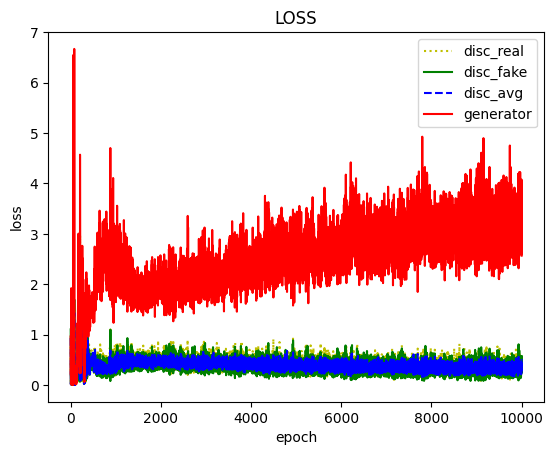

In [13]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(0, epoch)    # np.arange를 이용해 epoch만큼의 배열을 생성
plt.figure()
plt.plot(epochs, loss_disc_real, 'y:', label='disc_real')
plt.plot(epochs, loss_disc_fake, 'g-', label='disc_fake')
plt.plot(epochs, loss_disc_avg, 'b--', label='disc_avg')
plt.plot(epochs, loss_gan, 'r', label='generator')

plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

accuracy 그래프

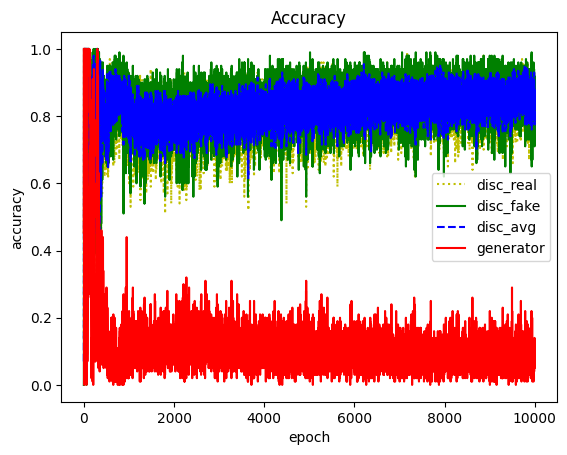

In [14]:
plt.figure()
plt.plot(epochs, acc_disc_real, 'y:', label='disc_real')
plt.plot(epochs, acc_disc_fake, 'g-', label='disc_fake')
plt.plot(epochs, acc_disc_avg, 'b--', label='disc_avg')
plt.plot(epochs, acc_gan, 'r', label='generator')

plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()
plt.show()

GAN으로 생성된 가짜 손글씨 data 확인

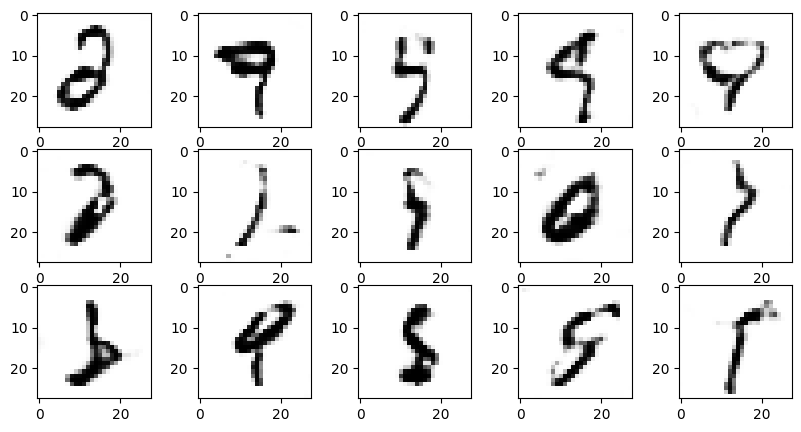

In [15]:
generated_imgs = 0.5 * gen_imgs + 0.5   # 우리가 만든 최종값은 음수이기에 0~1로 rescaling

plt.figure(figsize=(10, 5))
for i in range(3*5):
    plt.subplot(3, 5, i + 1)    # subplot설정
    plt.imshow(generated_imgs[i].reshape((28, 28)), cmap='Greys')
plt.show()

# epoch이 1일 때보다 훨씬 실제 손글씨와 가까움을 확인할 수 있다.